<a href="https://colab.research.google.com/github/davidwhogg/Sailing/blob/main/ipynb/sailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anisotropic ram-pressure sailing model

## to-do items:
- do all the things in this notebook labeled HOGG.
- Make the optimal route-planning.
- Solve the problem of setting both the sail and keel best if you want to go in a particular direction.
- Plot things in the air rest frame too.
- Label the plots with the direction cosines.
- Consider making the e-hat unit-vector things repeatedly called functions (reduce repeated code).
- Make the boat glyph something with a direction (a grey triangle, say).
- Make sure code clearly breaks degeneracies between `theta_s` and `theta_s - np.pi`

In [1]:
import numpy as np
import pylab as plt
import scipy.optimize as op
np.random.seed(17)

In [2]:
# create objects to hold the state of the world and the properties of the boat

class World():
    
    def __init__(self, vwater, vair):
        self.rho_water = 1.0 # kg / m^3
        self.rho_air = 0.0014 # kg / m^3
        self.vwater = vwater
        assert self.vwater.shape == (2, )
        self.vair = vair
        assert self.vair.shape == (2, )

class Boat():
    
    def __init__(self):
        self.A_perp_k = 1.0 # m^2
        self.A_perp_s = self.A_perp_k / 0.0014 # seems like sensible design
        self.A_par_k = 0.01 * self.A_perp_k # very optimistic
        self.A_par_s = 0.01 * self.A_perp_s # very optimistic

    def _get_A(self, Aperp, Apar, theta):
        ct = np.cos(theta)
        st = np.sin(theta)
        eperp = np.array([ct, st])
        epar = np.array([-st, ct])
        return Aperp * np.outer(eperp, eperp) + Apar * np.outer(epar, epar)

    def get_A_air(self, theta_s):
        return self._get_A(self.A_perp_s, self.A_par_s, theta_s)

    def get_A_water(self, theta_k):
        return self._get_A(self.A_perp_k, self.A_par_k, theta_k)
        

In [3]:
# create the world and the boat

world = World(np.zeros(2), np.array([8., 0.])) # water and air velocities
boat = Boat()

In [4]:
# force
TINY = 1.e-8

def _force(rho, dv, AA):
    absdv = np.sqrt(dv @ dv) + TINY
    return rho * absdv * AA @ dv, \
        - (rho / absdv) * AA @ np.outer(dv, dv) - rho * absdv * AA

def force(vboat, theta_s, theta_k, boat, world):
    """
    Compute the net force on a moving boat.
    """
    fa, dfadv = _force(world.rho_air, world.vair - vboat, boat.get_A_air(theta_s))
    fw, dfwdv = _force(world.rho_water, world.vwater - vboat, boat.get_A_water(theta_k))
    return fa + fw, dfadv + dfwdv

In [5]:
# use Newton's method to find the steady state

def get_vboat(theta_s, theta_k, boat, world, maxiter=100_000):
    """
    Use Newton's method to find the steady-state boat velocity.
    """
    vbig = 10. * np.sqrt(np.sum((world.vair - world.vwater) ** 2))
    vb = np.array([0., 0.])
    ff, dfdv = force(vb, theta_s, theta_k, boat, world)
    iter = 0
    while (ff @ ff) > 1.e-10 and iter < maxiter and np.all(vb < vbig):
        # print(iter, vb, ff, dfdv, np.linalg.solve(dfdv, ff))
        vb -= np.linalg.solve(dfdv, ff)
        ff, dfdv = force(vb, theta_s, theta_k, boat, world)
        iter += 1
    if iter >= maxiter:
        print("get_vboat(): WARNING: Terminated on maxiter.")
    if np.any(vb > vbig):
        print("get_vboat(): WARNING: Terminated on large velocity.")
    return vb

In [6]:
# viz

def hogg_arrow(ax, base, vector, c="k", lw=2, alpha=1., headlen=1.5):
    """
    This code exists because matplotlib has arrow issues that I can't abide.
    """
    vmag = np.linalg.norm(vector)
    thislen = vmag
    if vmag > headlen:
        thislen = headlen
    tipangle = 0.2 # rad
    ct, st = np.cos(tipangle), np.sin(tipangle)
    R = np.array([[ct, st], [-st, ct]])
    ltip = R @ vector * thislen / vmag
    rtip = R.T @ vector * thislen / vmag
    ax.plot([base[0], base[0] + vector[0], base[0] + vector[0] - ltip[0]],
            [base[1], base[1] + vector[1], base[1] + vector[1] - ltip[1]],
            color=c, ls="-", lw=lw, alpha=alpha)
    ax.plot([base[0] + vector[0], base[0] + vector[0] - rtip[0]],
            [base[1] + vector[1], base[1] + vector[1] - rtip[1]],
            color=c, ls="-", lw=lw, alpha=alpha)

def plot_boat(theta_s, theta_k, boat, world, ax=None):
    """
    This code is filled with hard-coded parameters; brittle.
    ONLY WORKS in the water rest frame right now.
    """
    if ax is None:
        ax = plt.gca()
    vb = get_vboat(theta_s, theta_k, boat, world)

    # set rest frame and plot the world
    restframe = "water rest frame"
    ax.text(-20., -20., restframe)
    vair = world.vair - world.vwater
    vb = vb - world.vwater
    hogg_arrow(ax, np.array([-20., 0.]), vair)
    ax.text(-20., 1., "wind")

    # plot the boat
    seigv = np.linalg.eigh(boat.get_A_air(theta_s))[1][0]
    sw = 8.
    ax.plot([-sw * seigv[0], sw * seigv[0]], [-sw * seigv[1], sw * seigv[1]], "k-", lw=1.)
    keigv = np.linalg.eigh(boat.get_A_water(theta_k))[1][0]
    kw = 4.
    ax.plot([-kw * keigv[0], kw * keigv[0]], [-kw * keigv[1], kw * keigv[1]], "k-", lw=6., alpha=0.2)
    hogg_arrow(ax, [0., 0.], vb)
    ax.set_xlim(-21, 21)
    ax.set_ylim(-21, 21)
    ax.set_aspect("equal")

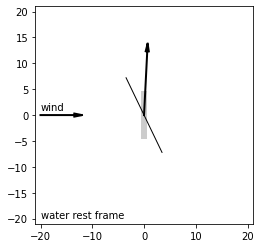

In [7]:
# check the plotting code
theta_k = 0.
theta_s = np.pi / 7.
plot_boat(theta_s, theta_k, boat, world)

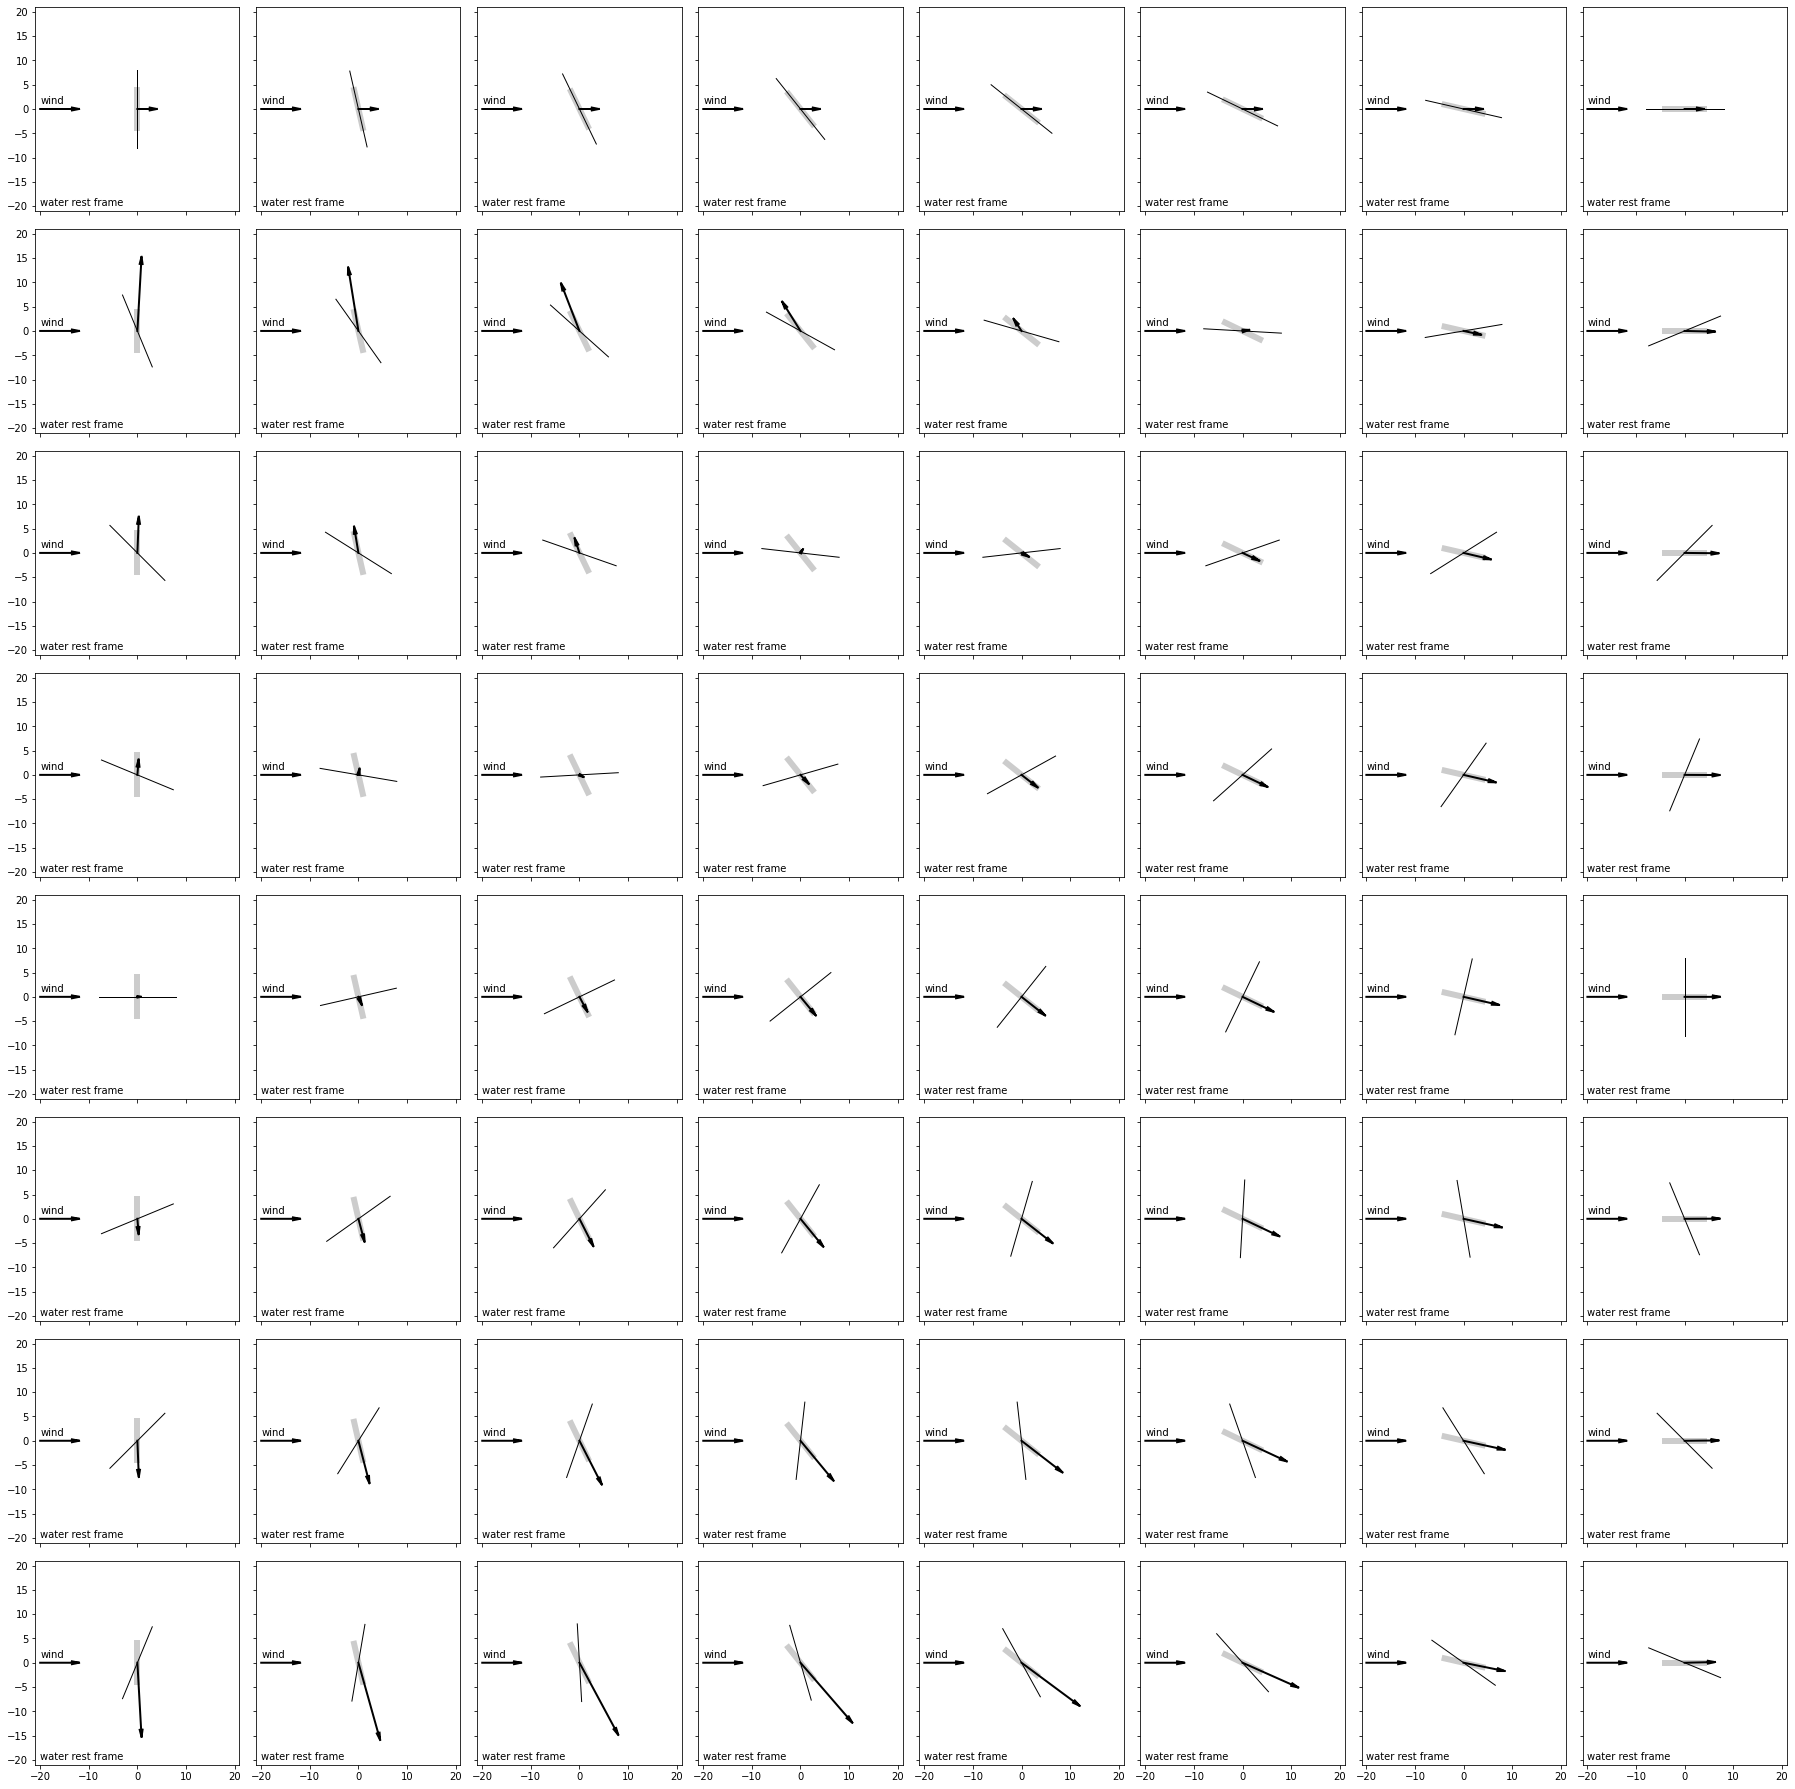

In [8]:
# a grid of cases
n1, n2 = 8, 8
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(25, 25), tight_layout=True)

for i in range(n1):
  for j in range(n2):
    theta_k = j * 0.5 * np.pi / (n2 - 1)
    theta_s = i * 1.0 * np.pi / n1 + np.pi + theta_k
    plot_boat(theta_s, theta_k, boat, world, ax=axes[i, j])

In [9]:
# time for Good Sailing (tm):

def sail_good(theta_k, boat, world):
    """
    Find the best theta_s given a theta_k:
    - Start with a grid search.
    - Then optimize with (gasp) Nelder-Mead.
    """
    def objective(theta_s, theta_k, boat, world):
        e_k_par = np.array([np.sin(theta_k), -np.cos(theta_k)]) # note: opposite of what you might think
        return e_k_par @ get_vboat(theta_s, theta_k, boat, world)
    ngrid = 64
    theta_ss = np.arange(0.5 * np.pi / ngrid, np.pi, np.pi / ngrid)
    obs = [objective(ts, theta_k, boat, world) for ts in theta_ss]
    theta_s0 = theta_ss[np.argmin(obs)]
    # plt.plot(theta_ss, obs, "ko")
    # print(theta_s0)
    res = op.minimize(objective, theta_s0, args=(theta_k, boat, world), method="Nelder-Mead")
    if not res.success:
        print(res)
        assert False
    return res.x[0]

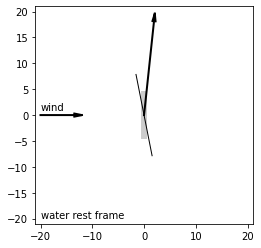

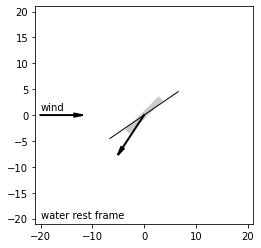

In [10]:
# test sail_good()
theta_k = 0.
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)
plt.figure()
theta_k = 0.75 * np.pi
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)

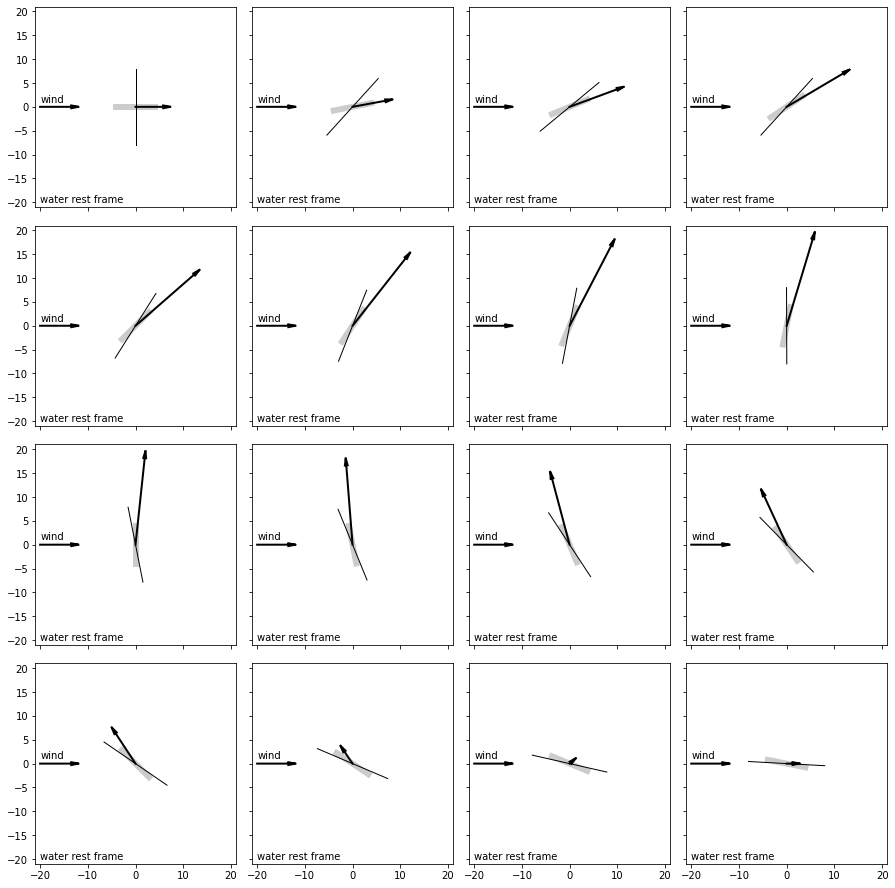

In [11]:
# a grid of cases
n1, n2 = 4, 4
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(12.5, 12.5), tight_layout=True)
axes = axes.flatten()

k = 0
for i in range(n1):
    for j in range(n2):
        theta_k = k * np.pi / (n1 * n2) - 0.5 * np.pi
        theta_s = sail_good(theta_k, boat, world)
        plot_boat(theta_s, theta_k, boat, world, ax=axes[k])
        k += 1

In [12]:
# now do a very large number of trials:

ntrials = 3000
vbs_random = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_s, theta_k = 2. * np.pi * np.random.uniform(size=(2))
    vb = get_vboat(theta_s, theta_k, boat, world)
    vbs_random[trial] = vb

ntrials = 100
vavbmax, vavbmin = 0., 0.
vbs_good = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_k = 2. * np.pi * np.random.uniform()
    theta_s_good = sail_good(theta_k, boat, world)
    vb = get_vboat(theta_s_good, theta_k, boat, world)
    vbs_good[trial] = vb
    if world.vair @ vb > vavbmax:
        vavbmax = world.vair @ vb
        downwind = (theta_s_good, theta_k)
    if world.vair @ vb < vavbmin:
        vavbmin = world.vair @ vb
        upwind = (theta_s_good, theta_k)

Text(0.5, 1.0, 'lots of best-sailing settings')

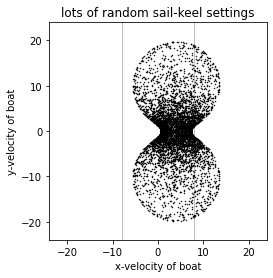

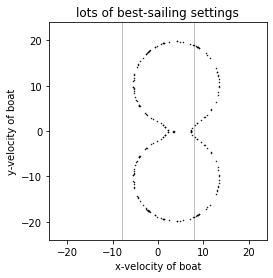

In [13]:
# HOGG: IS IT A COINCIDENCE THAT THIS LOOKS LIKE a projection of Y_10(theta, phi)?

plt.axvline(world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.axvline(-world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.plot(vbs_random[:, 0], vbs_random[:, 1], "k.", ms=1)
plt.plot(vbs_random[:, 0], -vbs_random[:, 1], "k.", ms=1) # WARNING: BRITTLE
plt.xlim(-24, 24)
plt.ylim(-24, 24)
plt.gca().set_aspect("equal")
plt.xlabel("x-velocity of boat")
plt.ylabel("y-velocity of boat")
plt.title("lots of random sail-keel settings")

plt.figure()
plt.axvline(world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.axvline(-world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.plot(vbs_good[:, 0], vbs_good[:, 1], "k.", ms=1)
plt.plot(vbs_good[:, 0], -vbs_good[:, 1], "k.", ms=1) # WARNING: BRITTLE
plt.xlim(-24, 24)
plt.ylim(-24, 24)
plt.gca().set_aspect("equal")
plt.xlabel("x-velocity of boat")
plt.ylabel("y-velocity of boat")
plt.title("lots of best-sailing settings")

Text(0.5, 1.0, 'best-ish upwind tack')

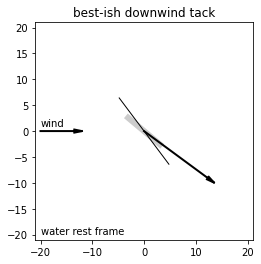

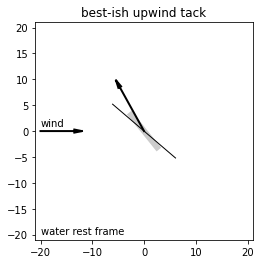

In [15]:
# show best upwind and downwind cases found so far.

plot_boat(*downwind, boat, world)
plt.title("best-ish downwind tack")
plt.figure()
plot_boat(*upwind, boat, world)
plt.title("best-ish upwind tack")

In [16]:
# now consier best-possible boat settings, given a vector towards the destination

# HOGG WARNING: THIS CODE IS NOT CORRECT BECAUSE IT DOES LOCAL OPTIMIZATION!
# I THINK WE NEED TO initialize with sail_good()
def get_best_thetas(r_dest, vair, vwater):
  def foo(pars):
    return -r_dest @ get_vboat(vair, vwater, *pars)
  theta_s0 = np.arctan2(r_dest[1], r_dest[0])
  theta_k0 = theta_k + 0.5 * np.pi
  res = op.minimize(foo, (theta_s0, theta_k0), method="Nelder-Mead")
  return res['x']

In [ ]:
r_dest = np.array([2., 1.])
best = get_best_thetas(r_dest, vair, vwater)
plot_boat(vair, vwater, *best)

In [ ]:
# now plot a course from A to B
# HOGG: WRONG: SEE ABOVE

def make_course(r_A, r_B, vair, vwater, dt = 0.1):
  bar = (r_B - r_A) @ (r_B - r_A)
  rr = 1. * r_A
  rrs = [rr, ]
  r_AB = r_B - rr
  while (rr - r_A) @ (r_B - r_A) < bar:
    best = get_best_thetas(r_AB, vair, vwater)
    vb = get_vboat(vair, vwater, *best)
    rr = rr + vb * dt
    r_AB = r_B - rr
    rrs.append(rr)
  return np.array(rrs)

In [ ]:
rA = np.array([0., 0.])
rB = np.array([-100., 100.])
rrs = make_course(rA, rB, vair, vwater)

In [ ]:
print(rrs.shape)
plt.plot([rA[0],], [rA[1],], "ko")
plt.plot([rB[0],], [rB[1],], "ro")
plt.plot(rrs[:,0], rrs[:,1], "k-")
plt.plot(rrs[:,0], rrs[:,1], "k.")
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("this plot is wrong")